In [1]:
import numpy as np
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import random

In [2]:
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/challenge_6/participants_dataset.zip' -d '/content/data/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/new_dataset_participants/files/4bb239ed-5d7b-4d5e-95a6-411440925ba1 2115.JPG  
  inflating: /content/data/__MACOSX/new_dataset_participants/files/._4bb239ed-5d7b-4d5e-95a6-411440925ba1 2115.JPG  
  inflating: /content/data/new_dataset_participants/files/89d2801e-6359-4079-a4c2-0df4718d7800 Leaf 1 Day 8.jpg  
  inflating: /content/data/__MACOSX/new_dataset_participants/files/._89d2801e-6359-4079-a4c2-0df4718d7800 Leaf 1 Day 8.jpg  
  inflating: /content/data/new_dataset_participants/files/6a3ae349-27f8-468c-a1ad-7ddfc31e3435 2471.JPG  
  inflating: /content/data/__MACOSX/new_dataset_participants/files/._6a3ae349-27f8-468c-a1ad-7ddfc31e3435 2471.JPG  
  inflating: /content/data/new_dataset_participants/files/36cf7d2c-a820-4311-9d16-443e04e13a15 0700.JPG  
  inflating: /content/data/__MACOSX/new_dataset_participants/files/._36cf7d2c-a820-4311-9d16-443e04e13a15 0700.JPG  
  inflating: /content/data/new_dataset_pa

In [5]:
def fix_seed_random(seed_value):
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value

    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value

    tf.random.set_seed(seed_value)
    tf.compat.v1.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    from keras import backend as K
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

    # 6. PyTorch seed
    import torch
    import torch.nn as nn
    torch.manual_seed(123)
    torch.cuda.manual_seed(123)
    torch.backends.cudnn.enabled=False
    torch.backends.cudnn.deterministic=True

fix_seed_random(0)

## Data exploration

In [6]:
base_path = "/content/data/new_dataset_participants/"
dataframe_filename = "participants_dataset.csv"
df = pd.read_csv(base_path+dataframe_filename)

train = df.dropna()
test = df[df["label"].isna()]

print(f"N data in train: {len(train)}")
print(f"N data in test: {len(test)}")
train.head()


N data in train: 8216
N data in test: 8052


,ID,filename,label
0,0,files/e2991a66-412d-4841-8dc0-524e38338a82 Lea...,Tomato_healthy
1,1,files/e9392a5e-2fac-48c5-a23d-df3aa3f61048 Lea...,Tomato_healthy
2,2,files/87a77f4d-38bd-42dc-bdd3-5f2a1fa95ca7 Lea...,Tomato_healthy
3,3,files/efe6c986-b85c-40f1-8cb5-345acbb36b71 057...,Tomato_healthy
4,4,files/cdf10741-0ed4-4a27-a2e9-8970e4426730 035...,Tomato_healthy


In [7]:
occur = train.groupby(['label']).size()
print(occur)

label
Pepper__bell___Bacterial_spot                  600
Pepper__bell___healthy                         600
Potato___Early_blight                          600
Potato___Late_blight                           600
Potato___healthy                               120
Tomato_Bacterial_spot                          600
Tomato_Early_blight                            600
Tomato_Late_blight                             600
Tomato_Leaf_Mold                               600
Tomato_Septoria_leaf_spot                      600
Tomato_Spider_mites_Two_spotted_spider_mite    600
Tomato__Target_Spot                            600
Tomato__Tomato_YellowLeaf__Curl_Virus          600
Tomato__Tomato_mosaic_virus                    296
Tomato_healthy                                 600
dtype: int64


In [8]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [9]:
base_path = "/content/data/new_dataset_participants/"
dataframe_filename = "participants_dataset.csv"
df = pd.read_csv(base_path+dataframe_filename)

train = df.dropna()
test = df[df["label"].isna()]

print(f"N data in train: {len(train)}")
print(f"N data in test: {len(test)}")
train.head()

N data in train: 8216
N data in test: 8052


,ID,filename,label
0,0,files/e2991a66-412d-4841-8dc0-524e38338a82 Lea...,Tomato_healthy
1,1,files/e9392a5e-2fac-48c5-a23d-df3aa3f61048 Lea...,Tomato_healthy
2,2,files/87a77f4d-38bd-42dc-bdd3-5f2a1fa95ca7 Lea...,Tomato_healthy
3,3,files/efe6c986-b85c-40f1-8cb5-345acbb36b71 057...,Tomato_healthy
4,4,files/cdf10741-0ed4-4a27-a2e9-8970e4426730 035...,Tomato_healthy


256
256
Tomato_healthy


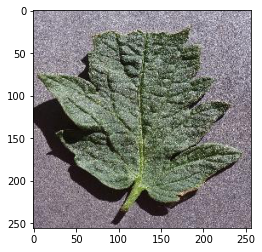

In [10]:
i = 455

sample = train.iloc[i].filename
label = train.iloc[i].label
sample_path = f"{base_path}{sample}"
image = load_img(sample_path)
plt.imshow(image)
print(image.height)
print(image.width)

print(label)

### Data generator

In [67]:
train, valid = train_test_split(train, test_size=0.18, random_state=0)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=base_path,
    x_col="filename",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256)
)

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=valid,
    directory=base_path,
    x_col="filename",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256)
)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

Found 5524 validated image filenames belonging to 15 classes.
Found 1213 validated image filenames belonging to 15 classes.


In [9]:
data, label = train_generator.next()

In [12]:
occur = valid.groupby(['label']).size()
# display occurrences of a particular column
print("Validation")
display(occur)

occur = train.groupby(['label']).size()
# display occurrences of a particular column
print("\nTraining")
display(occur)

Validation


label
Pepper__bell___Bacterial_spot                  117
Pepper__bell___healthy                         113
Potato___Early_blight                           98
Potato___Late_blight                            96
Potato___healthy                                17
Tomato_Bacterial_spot                          115
Tomato_Early_blight                            103
Tomato_Late_blight                             104
Tomato_Leaf_Mold                               113
Tomato_Septoria_leaf_spot                      104
Tomato_Spider_mites_Two_spotted_spider_mite     98
Tomato__Target_Spot                            127
Tomato__Tomato_YellowLeaf__Curl_Virus           90
Tomato__Tomato_mosaic_virus                     54
Tomato_healthy                                 130
dtype: int64


Training


label
Pepper__bell___Bacterial_spot                  483
Pepper__bell___healthy                         487
Potato___Early_blight                          502
Potato___Late_blight                           504
Potato___healthy                               103
Tomato_Bacterial_spot                          485
Tomato_Early_blight                            497
Tomato_Late_blight                             496
Tomato_Leaf_Mold                               487
Tomato_Septoria_leaf_spot                      496
Tomato_Spider_mites_Two_spotted_spider_mite    502
Tomato__Target_Spot                            473
Tomato__Tomato_YellowLeaf__Curl_Virus          510
Tomato__Tomato_mosaic_virus                    242
Tomato_healthy                                 470
dtype: int64

## Model


In [13]:
# CNN import 
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler

In [14]:
# Model Architecture 
def create_model(init_conv_size, conv_size, dense_size):
    model = models.Sequential()
    model.add(layers.Conv2D(init_conv_size, (3, 3), strides=2, input_shape=(256, 256, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(conv_size, (3, 3), strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(conv_size, (3, 3), strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(conv_size*2, (3, 3), strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(conv_size*2, (3, 3), strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(conv_size*2, (3, 3), strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(conv_size*2, (3, 3), strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))

    model.add(layers.MaxPooling2D((2, 2), strides=2))
    model.add(layers.Conv2D(conv_size*2, (3, 3), strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_size, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(dense_size/2, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.65))
    model.add(layers.Dense(15, activation='softmax'))
    return model

In [15]:
import math

In [16]:
def lr_decay(epoch, lr):
  """
  Return a reduced learning rate
  """
  k = 0.02
  return init_lr * math.exp(-k*epoch)

In [17]:
# Random Seed
seed = 100
fix_seed_random(seed)

# Model Name
model_name = 'model_1'

In [18]:
# Model creation
init_conv_sizes = 64
conv_sizes = 128
dense_sizes = 1024
f1_scores = []

model = create_model(init_conv_sizes, conv_sizes, dense_sizes)
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 127, 127, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 63, 63, 128)      5

In [69]:
# Random Seed
fix_seed_random(seed)

# Learning rate
init_lr = 0.001
# init_lr = 4.3171e-06

model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=55, validation_data=valid_generator, callbacks=[LearningRateScheduler(lr_decay, verbose=1)])


Epoch 1: LearningRateScheduler setting learning rate to 4.3171e-06.
Epoch 1/4
172/172 [==============================] - 96s 548ms/step - loss: 0.0980 - accuracy: 0.9683 - val_loss: 0.0293 - val_accuracy: 0.9909 - lr: 4.3171e-06

Epoch 2: LearningRateScheduler setting learning rate to 4.231615692532593e-06.
Epoch 2/4
172/172 [==============================] - 92s 534ms/step - loss: 0.0897 - accuracy: 0.9718 - val_loss: 0.0286 - val_accuracy: 0.9926 - lr: 4.2316e-06

Epoch 3: LearningRateScheduler setting learning rate to 4.147824087764494e-06.
Epoch 3/4
172/172 [==============================] - 90s 523ms/step - loss: 0.1068 - accuracy: 0.9638 - val_loss: 0.0221 - val_accuracy: 0.9942 - lr: 4.1478e-06

Epoch 4: LearningRateScheduler setting learning rate to 4.0656916679365595e-06.
Epoch 4/4
 50/172 [=======>......................] - ETA: 52s - loss: 0.1033 - accuracy: 0.9625

KeyboardInterrupt: ignored

### Save model

In [51]:
# Save model
from datetime import datetime
model_path_pre_valid = f'/content/drive/MyDrive/saved_{model_name}/model_without_validation-epoche-49'


In [52]:
model.save(model_path_pre_valid)

### Import model

In [68]:
model = tf.keras.models.load_model(model_path_pre_valid)

### Add validation data

In [70]:
# ~~~~~~~~~~ TRAIN WITH VALIDATION GENERATOR ~~~~~~~~~~
fix_seed_random(seed)
init_lr = 0.00005
epochs_valid = 2
model.fit(valid_generator, steps_per_epoch = len(valid) // 32, epochs=epochs_valid, validation_data=train_generator, callbacks=[LearningRateScheduler(lr_decay, verbose=1)])

model.save(f'saved_{model_name}/model_generator_validation')


Epoch 1: LearningRateScheduler setting learning rate to 5e-05.
Epoch 1/2
37/37 [==============================] - 33s 895ms/step - loss: 0.0910 - accuracy: 0.9763 - val_loss: 0.0351 - val_accuracy: 0.9918 - lr: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.900993366533776e-05.
Epoch 2/2
37/37 [==============================] - 32s 871ms/step - loss: 0.0784 - accuracy: 0.9771 - val_loss: 0.0320 - val_accuracy: 0.9876 - lr: 4.9010e-05


### Test on fake test data

In [21]:
fake_test_datagen=ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

fake_test_generator=fake_test_datagen.flow_from_dataframe(
    dataframe=fake_test,
    directory=base_path,
    x_col="filename",
    y_col=None,
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(256,256)
)
fake_test_generator.reset()
STEP_SIZE_TEST=fake_test_generator.n//fake_test_generator.batch_size
pred=model.predict(fake_test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

Found 474 validated image filenames.
474/474 [==============================] - 2s 5ms/step


In [22]:
pred[10]

array([1.0187644e-02, 6.7988353e-06, 1.5812825e-06, 2.1823048e-06,
       2.9450496e-07, 2.7291014e-06, 4.7476915e-06, 5.6529134e-05,
       2.2946771e-05, 9.8971409e-01, 1.5718827e-09, 4.6535327e-08,
       1.4221284e-07, 3.4731823e-07, 9.0536167e-10], dtype=float32)

In [23]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=fake_test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [24]:
occur = results.groupby(['Predictions']).size()
# display occurrences of a particular column
display(occur)

Predictions
Pepper__bell___Bacterial_spot                  29
Pepper__bell___healthy                         35
Potato___Early_blight                          28
Potato___Late_blight                           27
Potato___healthy                               15
Tomato_Bacterial_spot                          31
Tomato_Early_blight                            25
Tomato_Late_blight                             32
Tomato_Leaf_Mold                               22
Tomato_Septoria_leaf_spot                      72
Tomato_Spider_mites_Two_spotted_spider_mite    27
Tomato__Target_Spot                            37
Tomato__Tomato_YellowLeaf__Curl_Virus          33
Tomato__Tomato_mosaic_virus                    23
Tomato_healthy                                 38
dtype: int64

### Make prediction

In [71]:
submission_df = pd.read_csv(base_path+dataframe_filename)
test = submission_df[submission_df["label"].isna()]

test_datagen=ImageDataGenerator(
    rescale=1./255
)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=base_path,
    x_col="filename",
    y_col=None,
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(256,256)
)

Found 8052 validated image filenames.


In [72]:
test_generator.reset()
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
pred=model.predict(
    test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1
)

8052/8052 [==============================] - 36s 4ms/step


In [73]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
occur = results.groupby(['Predictions']).size()
# display occurrences of a particular column
display(occur)

for row in test.itertuples():
    id = row.ID
    idx = filenames.index(row.filename)
    submission_df.at[id, 'label'] = predictions[idx]

Predictions
Pepper__bell___Bacterial_spot                   386
Pepper__bell___healthy                          575
Potato___Early_blight                           390
Potato___Late_blight                            379
Potato___healthy                                 67
Tomato_Bacterial_spot                           786
Tomato_Early_blight                             469
Tomato_Late_blight                             1093
Tomato_Leaf_Mold                                390
Tomato_Septoria_leaf_spot                       679
Tomato_Spider_mites_Two_spotted_spider_mite     555
Tomato__Target_Spot                             532
Tomato__Tomato_YellowLeaf__Curl_Virus           956
Tomato__Tomato_mosaic_virus                     147
Tomato_healthy                                  648
dtype: int64

In [74]:
name = f"result-{time.time()}.csv"
print(name)
submission_df.to_csv(name)

result-1665329189.3262448.csv
